In [85]:
import numpy as np
import pickle
import pandas as pd
import re

In [296]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Merge player stats

In [148]:
with open('player_stats.pickle', 'rb') as handle:
    player_stats = pickle.load(handle)

In [149]:
all_seasons = []
for season_stats in player_stats:
    all_teams = []
    for team_stats in season_stats:
        team = pd.concat(team_stats, axis=1)
        all_teams.append(team)
    all_teams = pd.concat(all_teams, axis=0)
    all_seasons.append(all_teams)
all_stats = pd.concat(all_seasons)

## Clean column name

In [154]:
all_stats = all_stats.rename(columns = lambda x: re.sub(r'(Unnamed: \d_\w+_\d\s)|(\sUnnamed: \d_\w+_\d)|(\sUnnamed: \d_\w+_\d\s)', '', x))

In [155]:
all_stats = all_stats.loc[:,~all_stats.columns.duplicated()]

# Merge on off stats

In [178]:
with open('onoff_stats.pickle', 'rb') as handle:
    onoff_stats = pickle.load(handle)

In [179]:
all_seasons = []
for season_stats in onoff_stats:
    all_teams = []
    for team_stats in season_stats:
        team = pd.concat(team_stats, axis=1)
        all_teams.append(team)
    all_teams = pd.concat(all_teams, axis=0)
    all_seasons.append(all_teams)
all_stats_on_off = pd.concat(all_seasons)

## Clean column name

In [183]:
all_stats_on_off = all_stats_on_off.rename(columns = lambda x: re.sub(r'(Unnamed: \d_\w+_\d\s)|(\sUnnamed: \d_\w+_\d)|(\sUnnamed: \d_\w+_\d\s)', '', x))

In [184]:
all_stats_on_off.drop([x for x in list(all_stats_on_off.columns) if re.search(r'Unnamed', x)], axis=1, inplace=True)

In [185]:
all_stats_on_off = all_stats_on_off.loc[:,~all_stats_on_off.columns.duplicated()]

In [186]:
all_stats_on_off.shape

(9638, 103)

# Filter free agents

In [140]:
with open('free_agents.pickle', 'rb') as handle:
    free_agents = pickle.load(handle)

In [190]:
all_stats = all_stats.drop_duplicates(['Player', 'season'])

In [192]:
all_stats_on_off = all_stats_on_off.drop_duplicates(['Player', 'season'])

In [202]:
free_agents_stats = free_agents.merge(all_stats, how='left',
            left_on=['Player', 'previous season'],
            right_on=['Player', 'season']).merge(all_stats_on_off, how='left',
                                                left_on=['Player', 'previous season'],
                                                right_on=['Player', 'season'])

In [205]:
free_agents_stats.info('memory_usage'=='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4444 entries, 0 to 4443
Columns: 188 entries, Player to Opponent Shot Frequency AllThree #
dtypes: float64(113), object(75)
memory usage: 6.4+ MB


# Data Cleaning

In [228]:
import seaborn as sns

In [208]:
columns = free_agents_stats.columns

In [216]:
free_agents_stats.shape[0]

4444

In [218]:
columns_to_drop = []
for c in columns:
    if free_agents_stats[c].isnull().sum() == free_agents_stats.shape[0]:
        columns_to_drop.append(c)

In [219]:
free_agents_stats.drop(columns=columns_to_drop, inplace=True)

In [254]:
free_agents_stats = free_agents_stats.loc[free_agents_stats.apply(pd.Series.isnull, axis=0).apply(pd.Series.sum, axis=1).apply(lambda x: x <= free_agents_stats.shape[1]/3), :]

<AxesSubplot:>

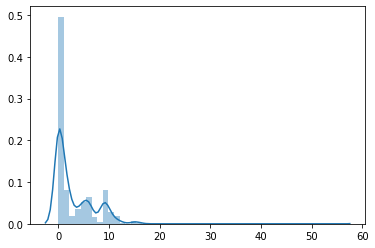

In [259]:
sns.distplot(a=free_agents_stats.apply(pd.Series.isnull, axis=0).apply(pd.Series.sum, axis=1).values)

In [260]:
free_agents_stats.fillna(0, inplace=True)

/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [269]:
[c for c in free_agents_stats.columns if ('_x' in c) or ('_y' in c)]

['MIN_x',
 'id_x',
 'season_x',
 'eFG% %_x',
 'eFG% #_x',
 'MIN_y',
 'id_y',
 'season_y',
 'eFG% %_y',
 'eFG% #_y']

In [270]:
free_agents_stats[[c for c in free_agents_stats.columns if ('_x' in c) or ('_y' in c)]]

,MIN_x,id_x,season_x,eFG% %_x,eFG% #_x,MIN_y,id_y,season_y,eFG% %_y,eFG% #_y
0,1763.0,3870,2004-05,59.0,48.2%,1763.0,3870,2004-05,47.0,-0.4%
1,1388.0,67,2004-05,89.0,54.0%,1388.0,67,2004-05,92.0,+3.2%
2,1784.0,250,2004-05,63.0,49.9%,1784.0,250,2004-05,53.0,-0.0%
4,1771.0,792,2004-05,80.0,52.5%,1771.0,792,2004-05,89.0,+2.7%
5,1998.0,797,2004-05,74.0,48.4%,1998.0,797,2004-05,71.0,+1.2%
...,...,...,...,...,...,...,...,...,...,...
4433,239.0,3346,2019-20,3.0,37.3%,239.0,3346,2019-20,7.0,-4.2%
4434,280.0,4691,2019-20,74.0,59.4%,280.0,4691,2019-20,12.0,-3.2%
4437,226.0,4324,2019-20,70.0,58.8%,226.0,4324,2019-20,89.0,+3.0%
4438,921.0,3627,2019-20,35.0,49.6%,921.0,3627,2019-20,68.0,+0.9%


In [ ]:
free_agents_stats.drop(columns=['MIN_y', 'id_y', 'season_y'], inplace=True)

In [272]:
free_agents_stats.rename({'MIN_x': 'MIN', 'id_x': 'id', 'season_x': 'season',
                          'eFG% %_x': 'Player eFG% %', 'eFG% #_x': 'Player eFG% #',
                          'eFG% %_y': 'Team eFG% %', 'eFG% #_y': 'Team eFG% #'}, axis=1, inplace=True)

/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


# Merge salary

In [279]:
free_agents_stats['Next season'] = free_agents_stats['season'].apply(lambda x: str(int(x[:4])+1) + "-" + str(int(x[:4])+2)[2:])

<ipython-input-279-114589cbbd4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_agents_stats['Next season'] = free_agents_stats['season'].apply(lambda x: str(int(x[:4])+1) + "-" + str(int(x[:4])+2)[2:])


In [313]:
with open("player_salaries.pickle", 'rb') as handle:
    player_salaries = pickle.load(handle)

In [315]:
player_salaries = pd.concat(player_salaries, axis=0)

In [321]:
player_salaries[player_salaries['Player']=='Jason Richardson']

,Player,Salary,season
54,Jason Richardson,8888888,2005-06
46,Jason Richardson,9999999,2006-07
48,Jason Richardson,11111110,2007-08
39,Jason Richardson,12664335,2008-09
31,Jason Richardson,13333333,2009-10
23,Jason Richardson,14444444,2010-11
126,Jason Richardson,5395000,2011-12
121,Jason Richardson,5799625,2012-13
121,Jason Richardson,6204250,2013-14
116,Jason Richardson,6601125,2014-15


In [316]:
stats_salaries = free_agents_stats.merge(player_salaries, how='left',
                        left_on=['Player', 'Next season'], right_on=['Player', 'season'])

In [322]:
stats_salaries = stats_salaries.loc[~stats_salaries['Salary'].isnull()]

In [324]:
stats_salaries.drop(columns=['season_x', 'season_y'], inplace=True)
stats_salaries.rename({})

['season_x', 'season_y']